In [597]:
dataset_names = {0:'usps',\
                 1:'satimage.scale',\
                 2:'dna.scale',\
                 3:'letter.scale',\
                 4:'pendigits',\
                 5:'news20.scale',\
                 6:'sector.scale',\
                 7:'mnist.scale',\
                 8:'cifar10',\
                 9:'toy',\
                 10:'rcv1',\
                 11:'aloi.scale'\
                }

nr_classes = {'usps':10,\
              'satimage.scale':6,\
              'dna.scale':3,\
              'letter.scale':26,\
              'pendigits':10,\
              'news20.scale':20,\
              'sector.scale':105,\
              'mnist.scale':10,\
              'cifar10':10,\
              'toy':3,\
              'rcv1':53,\
              'aloi.scale':1000\
             }

# as powers of ten
regs = {'usps':.1,\
        'satimage.scale':1,\
        'dna.scale':1,\
        'letter.scale':.1,\
        'pendigits':.01,\
        'news20.scale':.1,\
        'sector.scale':1,\
        'mnist.scale':1,\
        'cifar10':1,\
        'toy':1,\
        'rcv1':1,\
        'aloi.scale':1\
       }


iters = {'usps':2048,\
         'satimage.scale':64,\
         'dna.scale':1024,\
         'letter.scale':64,\
         'pendigits':8192,\
         'news20.scale':64,\
         'sector.scale':32,\
         'mnist.scale':64,\
         'cifar10':32,\
         'toy':32,\
         'rcv1':32,\
         'aloi.scale':32\
       }




run_these_datasets = [2,1,7,5,3,10,6,11]
run_these_hyperparams = [10,1,0.1,0.01]




In [598]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import math
import pandas as pd

In [599]:
pd.DataFrame({'ds_name' : [dataset_names[i] for i in run_these_datasets],
              'ds_idx' : run_these_datasets,
              'nr_classes' : [nr_classes[dataset_names[i]] for i in run_these_datasets],
              'baseline_reg' : [regs[dataset_names[i]] for i in run_these_datasets]
             })

,ds_name,ds_idx,nr_classes,baseline_reg
0,dna.scale,2,3,1.0
1,satimage.scale,1,6,1.0
2,mnist.scale,7,10,1.0
3,news20.scale,5,20,0.1
4,letter.scale,3,26,0.1
5,rcv1,10,53,1.0
6,sector.scale,6,105,1.0
7,aloi.scale,11,1000,1.0


# Run a single result

In [600]:
ds = dataset_names[7]
reg =.1

In [601]:
def get_exp_name(ds, reg):
    return ds+'_'+ str(int(math.log10(reg)))

In [602]:
get_exp_name(ds,reg)

'mnist.scale_-1'

In [603]:
def get_results(FILENAME):
    from numpy import genfromtxt
    result_np = genfromtxt(FILENAME, delimiter=',')

    df = pd.DataFrame(result_np, columns = ['time', 'sum of dual vars', 'norm/2', 'C*hinge risk', 'primal obj'])

    df['time'] = df['time']/1000 # convert from milliseconds to seconds
    df['dual obj'] = df['sum of dual vars'] - df['norm/2'] # add the column for the dual obj
    df['duality gap'] = df['primal obj'] - df['dual obj']
    return df

In [604]:
def get_time_conv(df,ratio):
    idx_conv = (df['duality gap'] <= ratio*df['duality gap'][0]).idxmax()
    return df['time'][idx_conv]

In [605]:
FILENAME = "../results/Ours/" + get_exp_name(ds,reg) + '.csv'
df_ours = get_results(FILENAME)
t_ours = get_time_conv(df_ours,0.01)

In [606]:
FILENAME = "../results/Shark/" + get_exp_name(ds,reg) + '.csv'
df_shark = get_results(FILENAME)
t_shark = get_time_conv(df_shark,0.01)

In [607]:
t_shark/t_ours

1.0534953304923382

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


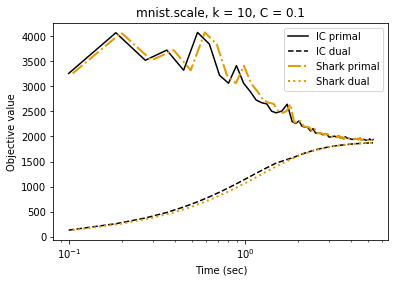

In [608]:

fig, ax = plt.subplots()
ax.semilogx(df_ours['time'],\
            df_ours['primal obj'],\
            linestyle='-', \
            color='k')
ax.semilogx(df_ours['time'], \
            df_ours['dual obj'], \
            linestyle='--', \
            color='k')

orange = (0.9,0.6,0)
ax.semilogx(df_shark['time'], \
            df_shark['primal obj'], \
            linestyle = '-.', \
            color = orange,\
            linewidth = 2)
ax.semilogx(df_shark['time'],\
            df_shark['dual obj'],\
            linestyle = ':', \
            color = orange,\
            linewidth = 2)


plt.xlabel("Time (sec)")
plt.ylabel("Objective value")
plt.title(ds + ', k = ' + str(nr_classes[ds]) +', C = ' +str(reg))
ax.legend(['IC primal','IC dual','Shark primal','Shark dual'])
plt.savefig('../figures/' + get_exp_name(ds,reg)+'_ob.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


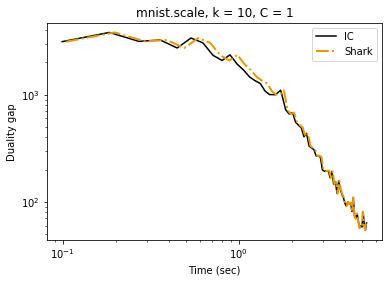

In [609]:


fig, ax = plt.subplots()
ax.loglog(df_ours['time'],\
            df_ours['duality gap'],\
            linestyle='-', \
            color='k')

orange = (0.9,0.6,0)
ax.loglog(df_shark['time'],\
            df_shark['duality gap'],\
            linestyle = '-.', \
            color = orange,\
            linewidth = 2)

plt.xlabel("Time (sec)")
plt.ylabel("Duality gap")
plt.title(ds + ', k = ' + str(nr_classes[ds]) +', C = ' +str(regs[ds]))
ax.legend(['IC','Shark'])
plt.savefig('../figures/' + get_exp_name(ds,reg)+'_dg.eps',format='eps')

# Get time ratios for all experiments

In [610]:

run_these_datasets = [2,1,7,5,3,10,6,11]
run_these_hyperparams = [10,1,0.1,0.01]

df_time = pd.DataFrame({'ds_name':[], 'regularizer':[], 'time_to_conv':[]})

row_id = 0
for i in run_these_datasets:
    for C in run_these_hyperparams:
        ds = dataset_names[i]
        reg = regs[ds]
        EXPNAME = get_exp_name(ds,C*reg)
        ratio = 0.1
        # print(EXPNAME)
        FILENAME = "../results/Ours/" + EXPNAME + '.csv'
        df_ours = get_results(FILENAME)
        t_ours = get_time_conv(df_ours,ratio)
        
        FILENAME = "../results/Shark/" + EXPNAME + '.csv'
        df_shark = get_results(FILENAME)
        t_shark = get_time_conv(df_shark,ratio)
        # print(t_shark/t_ours)
        
        df_time.loc[row_id] = [ds,C*reg, t_shark/t_ours]
        row_id = row_id + 1

df_time

,ds_name,regularizer,time_to_conv
0,dna.scale,10.000,0.842060
1,dna.scale,1.000,1.091580
2,dna.scale,0.100,0.970536
3,dna.scale,0.010,1.338086
4,satimage.scale,10.000,1.025974
5,satimage.scale,1.000,1.055937
6,satimage.scale,0.100,0.915160
7,satimage.scale,0.010,0.963013
8,mnist.scale,10.000,1.046213
9,mnist.scale,1.000,1.049670
